This notebook will use the CRISP Data Mining methology in order to solve the selected downstream task. The task at hand is to create a model that can take a medical image of a kidney and correctly classify it into one of the following categories: Normal, Tumor, Stone, Cyst. 

To solve this problem I will try two different methods. First, I will try to use two different Convolutional Neural Networks (CNNs) with a typical structure for image classification. And secondly I will use transfer learning with a pretrained network for image classification.

# Buisness Understanding

When inspecting the objectives and requirements of the project, one thing becomes very apparent. Since this task involves medical imagery and detection of possibly malignant tumors, we desire a model with high accuracy. In an industry setting, the misclassification of a tumor could have fatal consequences. Kidney stones and cysts rarely cause big problems for patients, and are thus less important to detect than tumors. However, in some cases they may become serious enough to cause pain and require treatment, and we need to detect them as well.

The second priority is that the model should not be unnecessarily complex. If we can choose a model with less parameters without loss of performance, this is definetly beneficial. This would allow the model to be faster and require less computational power.

The data mining goal is to create a model with high accuracy and a low misclassification rate of tumors. We can concider it a data mining success if we achieve an accuracy of 99% and a tumor misclassification rate of under 1%.

# Data Understanding

Dataset: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone?resource=download

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

 99% 1.50G/1.52G [00:12<00:00, 153MB/s]
100% 1.52G/1.52G [00:12<00:00, 129MB/s]


In [ ]:
! unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Strømmer utdata som er avkortet til de siste 5000 linjene.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-D

In [ ]:
data_dir = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

**Training and validation data for CNN**

I load the training and validation data in grayscale to fit and test my CNN.

In [ ]:
train_ds_gray = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  color_mode='grayscale',
  validation_split=0.3,
  subset="training",
  image_size=(224,224),
  shuffle=True,
  seed=123)

val_ds_gray = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  color_mode='grayscale',
  validation_split=0.3,
  image_size=(224,224),
  subset="validation",
  shuffle=True,
  seed=123)

Found 12446 files belonging to 4 classes.
Using 8713 files for training.
Found 12446 files belonging to 4 classes.
Using 3733 files for validation.


**Training and validation data for transfer learning**

I load the images as 'rgb' even though they are black-and-white images. This allows me to use models that are pretrained with colored images. If I loaded the images as 'grayscale' I would not be able to fit them to the model without adding a dense layer before the pretrained network with channel dimension 1 instead of 3. Doing this is counter-inuitive as I want to use the pretrained weights.

In [ ]:
train_ds_rgb = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  color_mode='rgb',
  validation_split=0.3,
  subset="training",
  image_size=(299,299),
  shuffle=True,
  seed=124)

val_ds_rgb = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  color_mode='rgb',
  validation_split=0.3,
  image_size=(299,299),
  subset="validation",
  shuffle=True,
  seed=124)

Found 12446 files belonging to 4 classes.
Using 8713 files for training.
Found 12446 files belonging to 4 classes.
Using 3733 files for validation.


In [ ]:
class_names = train_ds_gray.class_names
print(class_names)

['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
for image_batch, labels_batch in train_ds_gray:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 1)
(32,)


In [ ]:
for image_batch, labels_batch in train_ds_rgb:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 299, 3)
(32,)


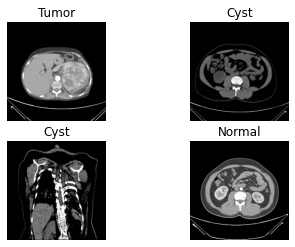

In [ ]:
for images, labels in train_ds_gray.take(1):
  for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        image = np.reshape(images[i], newshape=(224,224))
        plt.imshow(image, cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

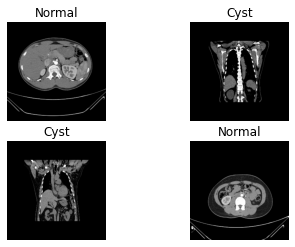

In [ ]:
for images, labels in train_ds_rgb.take(1):
  for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        image = np.reshape(images[i], newshape=(299,299,3))
        plt.imshow(image.astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data preparation

From the datacard on Kaggle, we can see that there are no missing values and no unlabeled images, so the dataset requires little preparation. 

To avoid class imbalance, we can inspect the number of instances of each class in the small training sets.

In [ ]:
num_classes = 4
count = np.zeros(num_classes, dtype=np.int32)
for _, labels in train_ds_gray:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()

print("In the grayscale training set: ")
for i in range(num_classes):
  print(f"There are {count[i]} instances of the class {class_names[i]}, which is {(count[i]/count.sum()*100).round(1)}% of the training set.")

In the grayscale training set: 
There are 2621 instances of the class Cyst, which is 30.1% of the training set.
There are 3538 instances of the class Normal, which is 40.6% of the training set.
There are 971 instances of the class Stone, which is 11.1% of the training set.
There are 1583 instances of the class Tumor, which is 18.2% of the training set.


In [ ]:
count = np.zeros(num_classes, dtype=np.int32)
for _, labels in train_ds_rgb:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()

print("In the rgb training set: ")
for i in range(num_classes):
  print(f"There are {count[i]} instances of the class {class_names[i]}, which is {(count[i]/count.sum()*100).round(1)}% of the training set.")

In the rgb training set: 
There are 2603 instances of the class Cyst, which is 29.9% of the training set.
There are 3543 instances of the class Normal, which is 40.7% of the training set.
There are 967 instances of the class Stone, which is 11.1% of the training set.
There are 1600 instances of the class Tumor, which is 18.4% of the training set.


We can see that there is a slight class imbalance, but not enough to cause problems.

An important part of data preparation for image processing is to normalize pixel values. This is done in the first layer of the CNNs with the "Rescaling" layer. The TL model requires the pixel values to be in the range [-1,1], and this is done with the preprocess_input function.

# Modeling

**Convolutional Neural Network**

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
  optimizer='adam',
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy'])

In [ ]:
model.fit(train_ds_gray, validation_data=val_ds_gray, epochs=3)

Epoch 1/3
273/273 [==============================] - 15s 19ms/step - loss: 0.2775 - accuracy: 0.8996 - val_loss: 0.0192 - val_accuracy: 0.9962
Epoch 2/3
273/273 [==============================] - 5s 18ms/step - loss: 0.0283 - accuracy: 0.9909 - val_loss: 8.8567e-04 - val_accuracy: 1.0000
Epoch 3/3
273/273 [==============================] - 5s 18ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.0012 - val_accuracy: 0.9997


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 93312)             0

The first CNN is a deep network with a traditional structure for image classification, with the convolutional layers followed by pooling layers. This part of the network is intended to extract the features of the images. The last dense layers should then use these features to make the classification. From the summary we see that it is a fairly complex model with almost 3 million parameters.

**Convolutional Neural Network (Smaller model)**

In [ ]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(24, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model2.compile(
  optimizer='adam',
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy'])

In [ ]:
model2.fit(train_ds_gray, validation_data=val_ds_gray, epochs=3)

Epoch 1/3
273/273 [==============================] - 6s 19ms/step - loss: 0.1647 - accuracy: 0.9496 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 2/3
273/273 [==============================] - 5s 18ms/step - loss: 0.0034 - accuracy: 0.9999 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 3/3
273/273 [==============================] - 5s 18ms/step - loss: 9.9806e-04 - accuracy: 1.0000 - val_loss: 9.9664e-04 - val_accuracy: 1.0000


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 24)      240       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 24)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 131424)            0         
                                                                 
 dense_2 (Dense)             (None, 4)                 525700    
                                                                 
Total params: 525,940
Trainable params: 525,940
Non-trainable params: 0
________________________________________________

The second CNN is a smaller model with only one convolutional and one pooling layer, followed by the final classification layer. This model is significantly less complex with around 525 000 parameters.

**Transfer learning with Xception**

In [ ]:
def preprocess(images, labels):
  return tf.keras.applications.xception.preprocess_input(images), labels

In [ ]:
train_ds_rgb = train_ds_rgb.map(preprocess)
val_ds_rgb = val_ds_rgb.map(preprocess)

base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)

for layer in base_model.layers:
  layer.trainable = False

input = tf.keras.Input(shape=(299,299,3))
x = base_model(input)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

tl_model = tf.keras.models.Model(inputs=input, outputs=x)

In [ ]:
tl_model.compile(
  optimizer='adam',
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy']
)

In [ ]:
tl_model.fit(train_ds_rgb, validation_data=val_ds_rgb, epochs=3)

Epoch 1/3
273/273 [==============================] - 20s 64ms/step - loss: 0.9913 - accuracy: 0.9084 - val_loss: 0.4010 - val_accuracy: 0.9472
Epoch 2/3
273/273 [==============================] - 17s 61ms/step - loss: 0.1191 - accuracy: 0.9814 - val_loss: 0.0642 - val_accuracy: 0.9898
Epoch 3/3
273/273 [==============================] - 17s 61ms/step - loss: 0.0527 - accuracy: 0.9922 - val_loss: 0.0722 - val_accuracy: 0.9909


In [ ]:
tl_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten_10 (Flatten)        (None, 204800)            0         
                                                                 
 dense_11 (Dense)            (None, 4)                 819204    
                                                                 
Total params: 21,680,684
Trainable params: 819,204
Non-trainable params: 20,861,480
_________________________________________________________________


The transfer learning model uses "Xception" as the base model for feature extraction. I load the base model with the weights from "imagenet" and set all the layers to non-trainable. Additionally, I choose to not include the top of the model, this is because we don't want to include the final classification layers of "Xception", we want it to classify according to our 4 classes. That is what the final Dense layer is for. This is a very large model with over 21 million parameters. 

# Evaluation

From fitting the models, we saw that the larger CNN got a validation accuracy of 0.9997 and the smaller model got 1.00. The TL model got a slightly lower validation accuracy of 0.9909.

In [ ]:
def create_confusion_matrix(model, validation_set):
  batch_count_val = validation_set.cardinality().numpy()
  labels = []
  predictions = []
  for x,y in validation_set.take(batch_count_val-1):
    predictions.append(np.argmax(model.predict(x), axis=-1))
    labels.append(y)

  labels = tf.convert_to_tensor(np.array(labels).flatten())
  predictions = tf.convert_to_tensor(np.array(predictions).flatten())

  return confusion_matrix(labels, predictions)

In [ ]:
def plot_confusion_matrix(cm, title, class_names):
  %matplotlib inline
  plt.rcParams['figure.figsize'] = (10,10)
  plt.rcParams['font.size'] = 20
  display_cm = ConfusionMatrixDisplay(cm, display_labels=class_names)
  display_cm.plot(cmap='OrRd', xticks_rotation=25)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.title(title, fontsize=24)
  plt.show()

In [ ]:
m1_cm = create_confusion_matrix(model, val_ds_gray)
m2_cm = create_confusion_matrix(model2, val_ds_gray)
tl_cm = create_confusion_matrix(tl_model, val_ds_rgb)

1/1 [==============================] - 0s 37ms/step


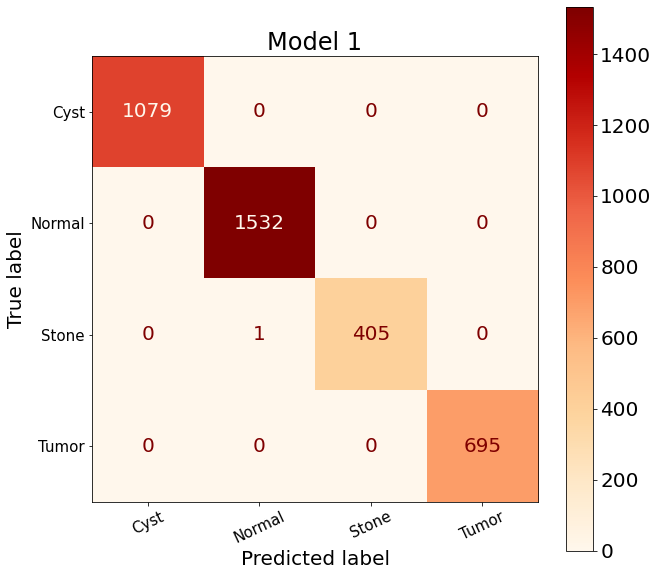

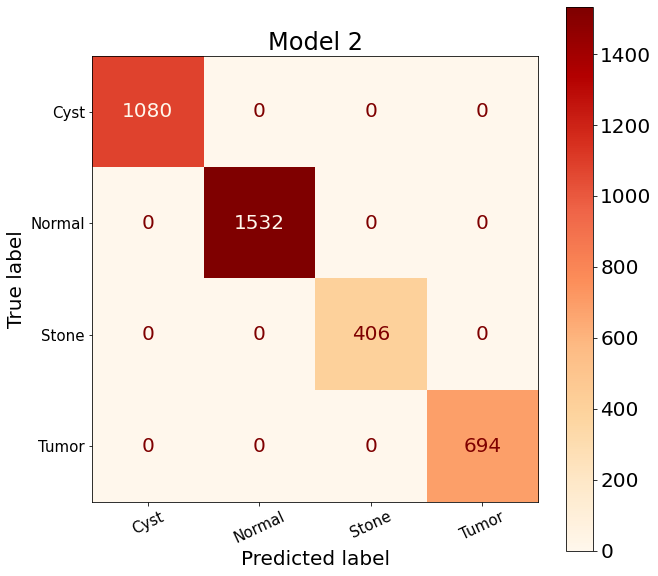

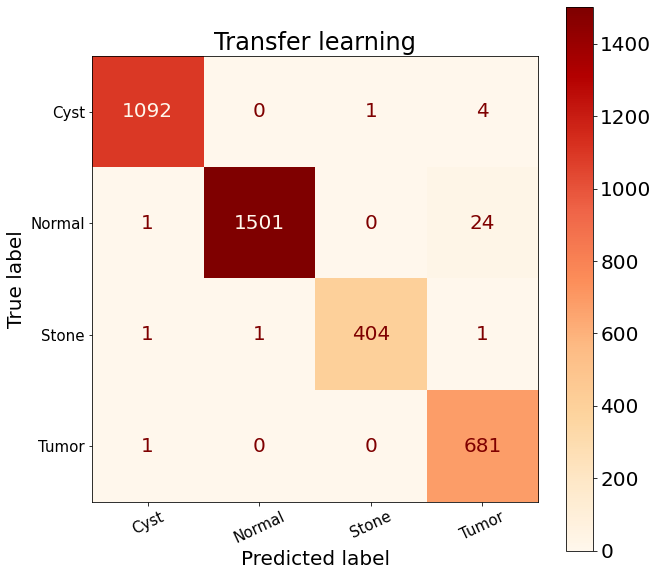

In [ ]:
plot_confusion_matrix(m1_cm, "Model 1", class_names)
plot_confusion_matrix(m2_cm, "Model 2", class_names)
plot_confusion_matrix(tl_cm, "Transfer learning", class_names)

From the confusion matrices we see that the second CNN got all classifications correct, while the first CNN made 1 mistake. The TL model had some misclassifications for all the classes. The most common mistake it made was to predict tumor when the true label was normal.

It turns out that using transfer learning with Xception was a bit "overkill" for this task. The base model is intended for much more complex tasks and it can classify objects into 1000 different classes. When a CNN with only a fraction of its parameters has better performance, TL is obviously not the optimal solution for this problem. It should be mentioned that it is probably possible to increase the performance of this model by finetuning it, but it still doesn't change the conclusion that it is too complex for this purpose. 

In terms of the data mining goal that were stated in the "Buisness Understanding" section, all 3 models achieved accuracy over 99% and a tumor misclassification rate under 1%.

**SOTA models**

Image classification: https://paperswithcode.com/sota/image-classification-on-imagenet

Medical image classification: https://paperswithcode.com/sota/medical-image-classification-on-nct-crc-he

When comparing these results to SOTA models for image classification, we see that the best model "CoCa" has an accuracy of 91%. However, this is based on the "ImageNet" dataset and is a much harder classification task, so not that relevant as a direct comparison.

The best model for medical image classification "Efficientnet-b0" has an accuracy of 95.59%. This is based on a dataset with normal and cancer tissue and the classification consits of 9 classes. This is more comparable than the last case, but still a harder classification task.

Comparison with other users on Kaggle show similar results with accuracy around 0.99. 

# Deployment

These results show that both CNNs are very good and accurate models. It turns out that this classification task was very easy for convolutional networks. In an optimal situation, we would have a much larger dataset to test the models and confidently determine which one is the most precise. However, from these results it seems beneficial to choose the smaller model with less computational complexity.